# Example: Dataset CEAP-360VR with pandas and scikit-learn

This notebook loads and preprocesses the dataset `CEAP-360VR` [GitHub repo](https://github.com/luiseduve/CEAP-360VR-Dataset) described in the paper:

*CEAP-360VR: A Continuous Physiological and Behavioral Emotion Annotation Dataset for 360 VR Videos* [(DOI)](10.1109/TMM.2021.3124080)

*Description:* 

1. A class was created to load the individual Json files in a structured way through the index file `data_tree_index.json`. Similarly, demographics and video stimuli information are stored in two .csv files. The `Frame` data was used as main data source.
2. The sampling frequency is different among data modalities, they were normalized to 30Hz for all videos (Video1 was at 25Hz). Moreover, we loaded `Raw` IBI to generate new signals `IBI_R_Peaks` indicating with a 1 when a heart-rate beat was detected. This information is useful for HRV analysis.
3. Finally, the dataset is combined in a single dataframe containing all data @30Hz, without missing values and with target class labels to be used in classification tasks.

In [1]:
import ceap_loader

# Libs for data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

---
## Setup

In [2]:
# All the files generated from this notebook are in a subfolder with this name
STR_DATASET = "ceap_example/"

In [3]:
def gen_path_temp(filename, subfolders="", extension=".csv"):
    # Function to generate temporary files easier
    TEMP_FOLDER_NAME = "./temp/"
    return ceap_loader.generate_complete_path(filename, \
                                        main_folder=TEMP_FOLDER_NAME, \
                                        subfolders=STR_DATASET+subfolders, \
                                        file_extension=extension)

---
# 1) Loading the dataset as CSV
---

In [4]:
# Define the root folder of the dataset with respect to the notebook
dataset_root_folder = "../../../CEAP-360VR/"
print(dataset_root_folder)

../../../CEAP-360VR/


The class `DatasetCEAP()` generates three files in the same folder of the dataset:
1. `data_tree_index.json`: The index containing the relative paths of the data files, grouped per data type (*Annotations, Behavior, Physio*), processing level (*Raw, Transformed, Frame*) and participant (*From 1 to 32*).
2. `demographics_info_summary.csv`: A table that summarizes, per participant, the demographic information, subjective ratings from the questionnaires, and when the participant watched each of the 8 stimuli videos.
3. `video_info_summary.csv`: A table describing the metadata from the video as in the folder `1_Stimuli`.

In [5]:
data_manager = ceap_loader.DatasetCEAP(dataset_root_folder)

Index already exists: Loading from  ../../../CEAP-360VR/data_tree_index.json


In [6]:
# Access the stimuli data
data_manager.stimuli

,VideoID,VideoFileName,VideoResolutionWidth,VideoResolutionHeight,VideoDuration,FrameRate,FrameCount,VideoLink,OriginalValence,OriginalArousal,PilotStudyValence,PilotStudyArousal
0,V0,NASA: Encapsulation & Launch of OSIRIS Rex,3840,2048,60,30,1816,D7-AmamuJEA,6.36,5.93,0.00,0.00
1,V1,Puppies host SourceFed for a day,3840,1920,60,25,1501,c7sA3EdXSUQ,7.47,5.35,7.08,6.08
2,V2,Mountain Stillness,3840,1920,60,30,1801,aePXpV8Z10Y,6.13,1.80,8.08,1.92
3,V3,Zombie Apocalypse Horror,3840,1920,59,30,1795,pHX3U4B6BCk,3.20,5.60,2.58,6.83
4,V4,War Zone,3840,2048,60,30,1803,Nxxb_7wzvJI,2.53,3.82,2.42,4.17
5,V5,Speed Flying,3840,1920,60,30,1801,g6w6xkQeSHg,6.75,7.42,6.83,7.42
6,V6,Malaekahana Sunrise,3840,1920,60,30,1801,-bIrUYM-GjU,6.57,1.57,7.67,1.50
7,V7,Jailbreak 360,3840,2048,60,30,1801,vNLDRSdAj1U,4.40,6.70,4.42,7.17
8,V8,The Nepal Earthquake Aftermath,3840,2048,60,30,1801,5tasUGQ1898,2.73,3.80,2.17,3.17


In [7]:
# Access the demographics dataframe
data_manager.demographics.head(2)

,ParticipantID,Age,Gender,VR Experience,Profession,FirstGroup,VideoOrder,SSQ 0,SSQ 1,SSQ 2,...,V6_ArousalValue,V6_Video_Duration_in_Length,V7_start_UnixTimestamp,V7_ValenceValue,V7_ArousalValue,V7_Video_Duration_in_Length,V8_start_UnixTimestamp,V8_ValenceValue,V8_ArousalValue,V8_Video_Duration_in_Length
0,10,22,Female,Less than 5 times,student,HaloLight,8 7 6 5 1 4 2 3,1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1,2 1 1 2 1 1 1 1 1 2 1 2 1 1 1 1,2 1 2 2 1 1 1 1 2 1 1 1 1 1 1 1,...,1,60.112,1582100169136,5,4,60.129,1582100074708,3,1,60.095
1,11,27,Male,First time,student,HaloLight,4 3 2 1 6 7 8 5,1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,...,1,60.137,1582104946808,3,5,60.154,1582105047580,2,3,60.112


## Plotting data from one participant

In [8]:
# Parameters of data to load
pid = 1         # 1-32
typ = "Physio"  # ["Annotations", "Behavior", "Physio"]
prep = "Frame"    # ["Raw", "Transformed", "Frame"]

# Load data 
data_loaded = data_manager.load_data_from_participant(pid,typ,prep)
data_loaded.head()

Loading from:  ../../../CEAP-360VR/5_PhysioData\Frame\P1_Physio_FrameData.json


,data_type,processing_level,ParticipantID,VideoID,TimeStamp,ACC_ACC_X,ACC_ACC_Y,ACC_ACC_Z,SKT_SKT,EDA_EDA,BVP_BVP,HR_HR,IBI_IBI
0,Physio,Frame,1,1,0.00,-52.000000,23.0,30.000000,0.000000,0.165399,0.193771,85.530000,NaN
1,Physio,Frame,1,1,0.04,-52.291183,23.0,30.000000,0.000375,0.179468,0.118313,85.526798,NaN
2,Physio,Frame,1,1,0.08,-52.435832,23.0,30.000000,0.000750,0.193538,0.210542,85.523596,NaN
3,Physio,Frame,1,1,0.12,-52.000000,23.0,29.158708,0.001125,0.207608,0.458494,85.520394,NaN
4,Physio,Frame,1,1,0.16,-52.000000,23.0,30.000000,0.001500,0.221677,0.709096,85.517191,NaN


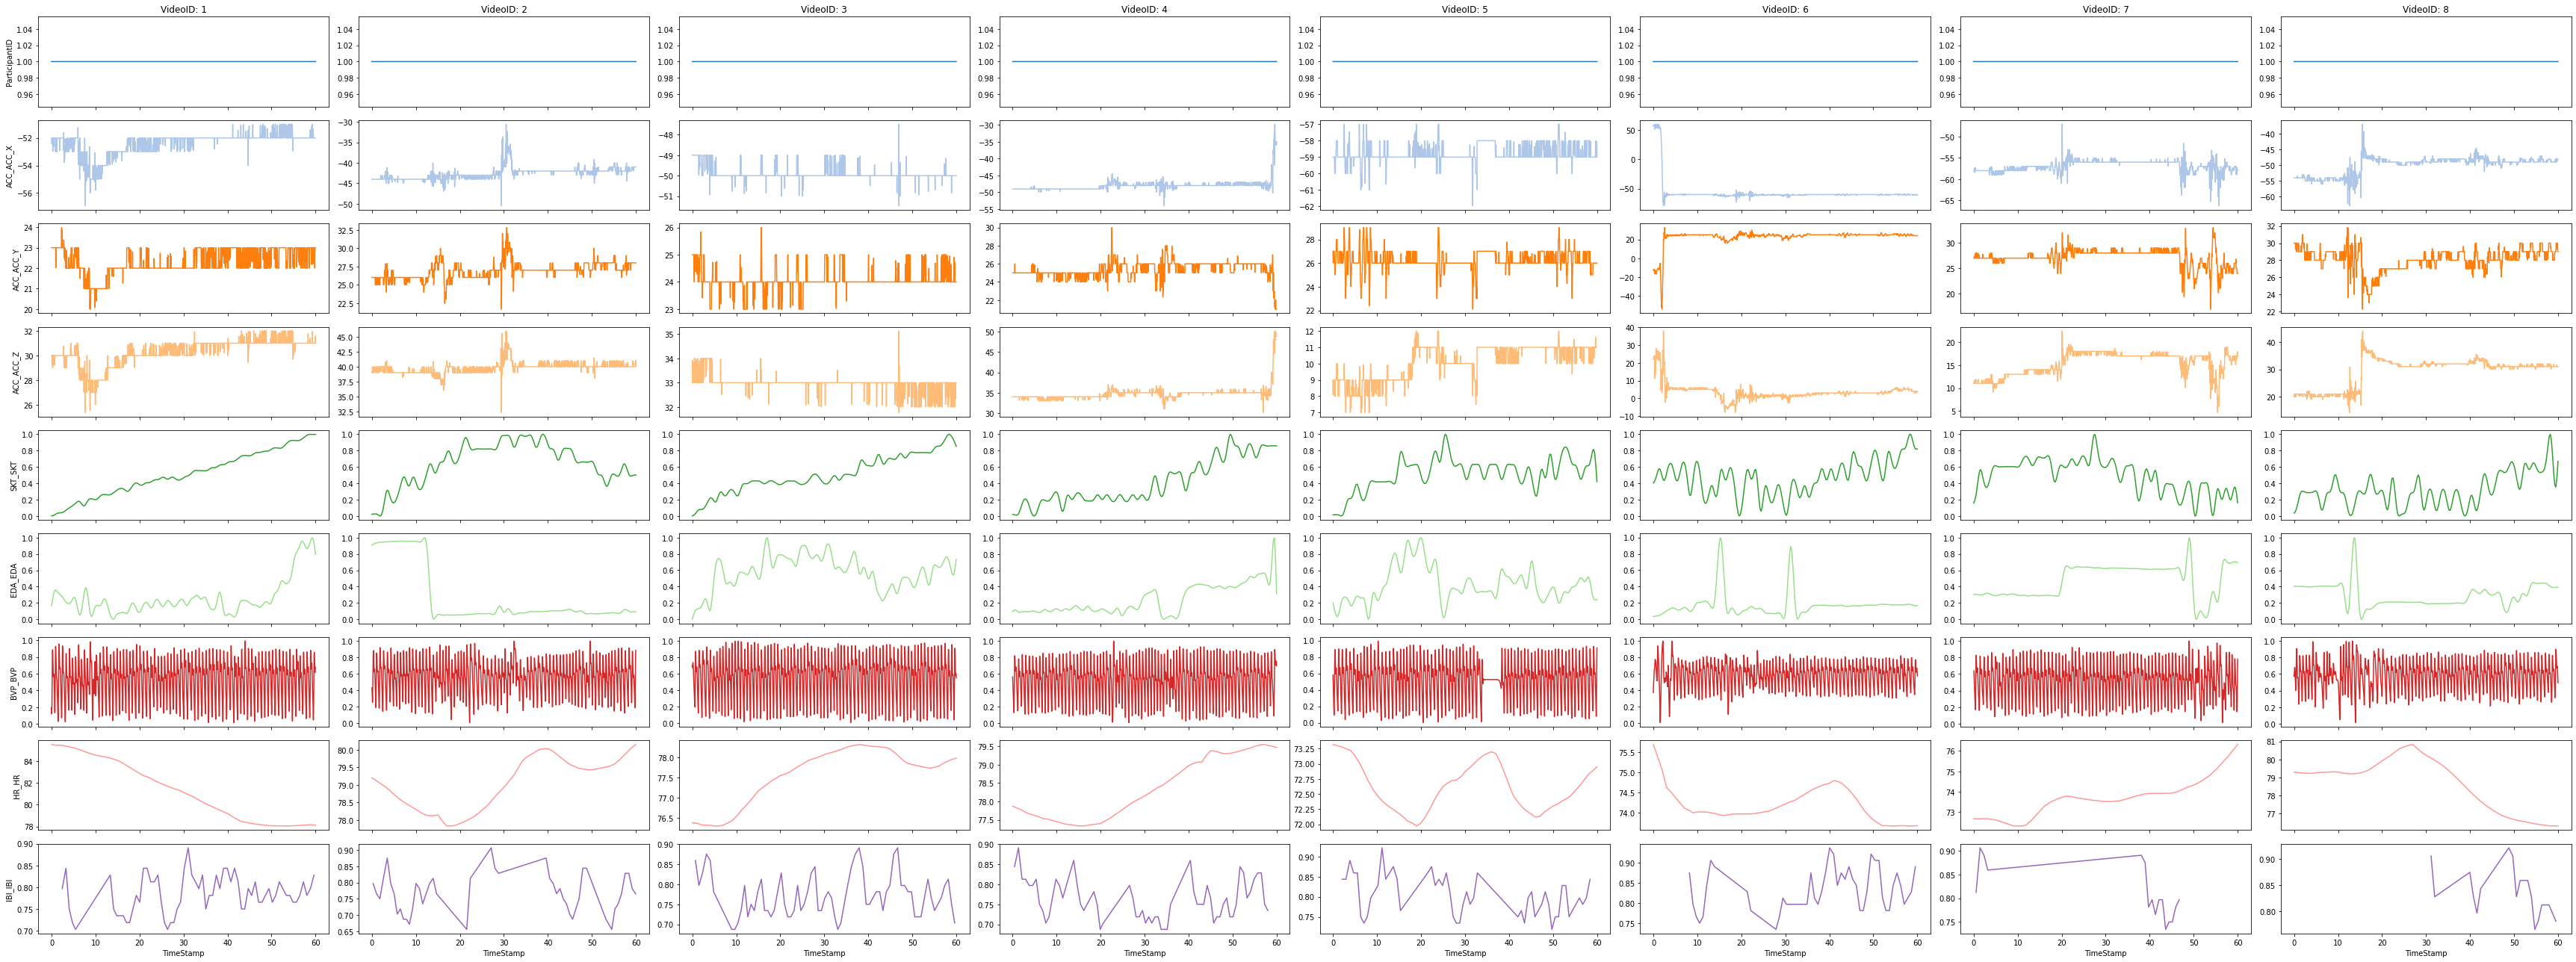

In [9]:
# Plots all data from a participant, dividing per videoId and data type.
ceap_loader.plot_all_data_from_participant(data_loaded)

## Plotting and saving to PNG file

Loading from:  ../../../CEAP-360VR/3_AnnotationData\Raw\P5_Annotation_RawData.json


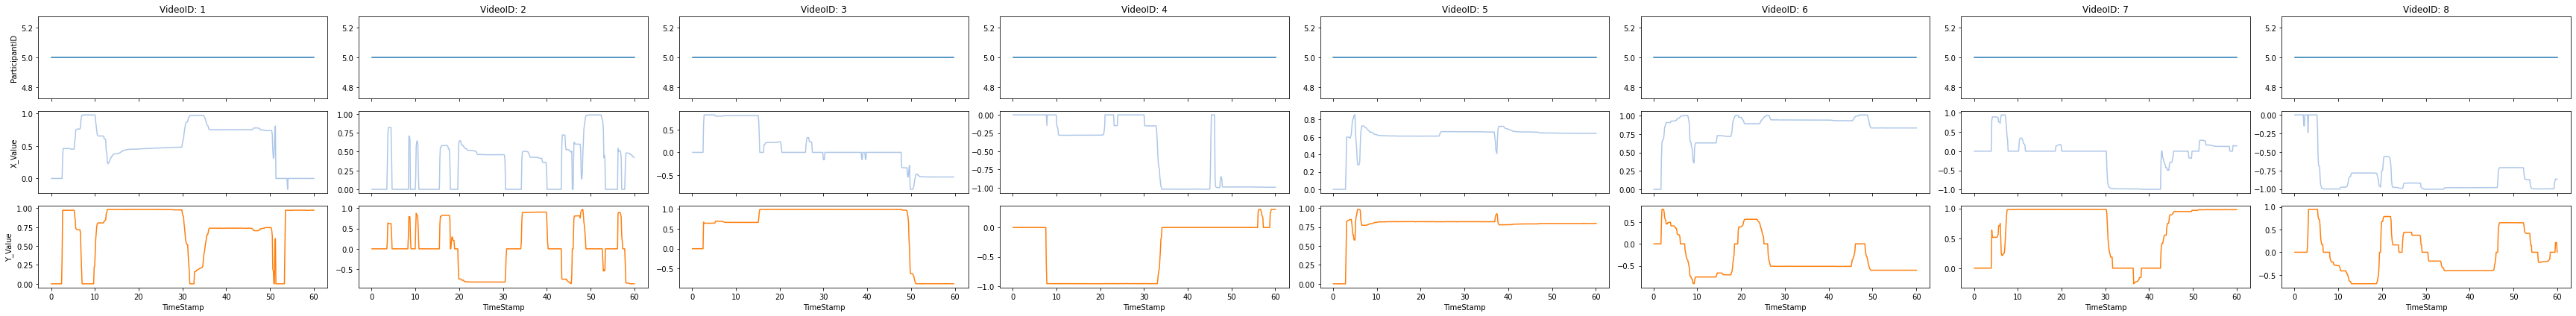

In [10]:
# Load data from a new participant
data_loaded = data_manager.load_data_from_participant(5,"Annotations","Raw")

# Create the plot
ceap_loader.plot_all_data_from_participant(data_loaded)

# Save the plot in a custom folder (in this case "./temp/")
save_path_plot = gen_path_temp(f"plot_test",subfolders="plots/",extension=".png")
fig = plt.gcf()
fig.savefig(save_path_plot, dpi=300)

### Plot the data from all file in the dataset

**Uncomment if needed** The cell below takes **>2 hours** plotting the whole dataset, per loaded file.

In [11]:
# ## Generate plots per data type and to visualize all the data per participant
# for typ in data_manager.LIST_DATA_TYPES:
#     for prep in data_manager.LIST_PROCESSING_LEVELS:
#         for pid in range(1,33):
#             data_loaded = data_manager.load_data_from_participant(pid,typ,prep)
#             ceap_loader.plot_all_data_from_participant(data_loaded)
#             save_path_plot = gen_path_temp(f"{prep}/Participant{pid}_{typ}",subfolders="plots/",extension=".png")
#             fig = plt.gcf()
#             fig.savefig(save_path_plot, dpi=200)
#             plt.close()

## Generate a CSV with data of interest

In the example below, we load the data from all participants, all data types, and processing level `Frame`. 

Creating a CSV file for the whole dataset produces a CSV file of `~800MB`.

In [12]:
# Participants IDS
PARTICIPANTS_IDS = np.arange(1,33)
# Load data Annotations, Behavior, and Physio
DATA_GROUPS = data_manager.LIST_DATA_TYPES
# Load the Raw, Transformed, or Frame (resampled) data processing
DATA_PROCESSING_LEVELS = data_manager.LIST_PROCESSING_LEVELS
print(f"DATA_GROUPS={DATA_GROUPS}, DATA_PROCESSING_LEVELS={DATA_PROCESSING_LEVELS}")

DATA_GROUPS=['Annotations', 'Behavior', 'Physio'], DATA_PROCESSING_LEVELS=['Raw', 'Frame', 'Transformed']


In [13]:
# Load or create dataframe with statistics of initial dataset
df_ceap = None

# Load all data resampled by frame
for pid in PARTICIPANTS_IDS:     # Which participants to load
    for dttype in DATA_GROUPS:   # Which data type to load
        for prep in ["Frame"]:   # Which processing level
            df_single_file = data_manager.load_data_from_participant(pid, dttype, prep)
            df_ceap = df_single_file if (df_ceap is None) else pd.concat([df_ceap, df_single_file], axis=0)

Loading from:  ../../../CEAP-360VR/3_AnnotationData\Frame\P1_Annotation_FrameData.json
Loading from:  ../../../CEAP-360VR/4_BehaviorData\Frame\P1_Behavior_FrameData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Frame\P1_Physio_FrameData.json
Loading from:  ../../../CEAP-360VR/3_AnnotationData\Frame\P2_Annotation_FrameData.json
Loading from:  ../../../CEAP-360VR/4_BehaviorData\Frame\P2_Behavior_FrameData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Frame\P2_Physio_FrameData.json
Loading from:  ../../../CEAP-360VR/3_AnnotationData\Frame\P3_Annotation_FrameData.json
Loading from:  ../../../CEAP-360VR/4_BehaviorData\Frame\P3_Behavior_FrameData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Frame\P3_Physio_FrameData.json
Loading from:  ../../../CEAP-360VR/3_AnnotationData\Frame\P4_Annotation_FrameData.json
Loading from:  ../../../CEAP-360VR/4_BehaviorData\Frame\P4_Behavior_FrameData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Frame\P4_Physio_FrameData.json
Load

In [14]:
df_ceap[ df_ceap["data_type"]=="Physio" ].isna().sum(axis=0)

data_type                0
processing_level         0
ParticipantID            0
VideoID                  0
TimeStamp                0
Valence             465085
Arousal             465085
HM_Pitch            465085
HM_Yaw              465085
EM_Pitch            465085
EM_Yaw              465085
LEM_Pitch           465085
LEM_Yaw             465085
REM_Pitch           465085
REM_Yaw             465085
LPD_PD              465085
RPD_PD              465085
ACC_ACC_X            13885
ACC_ACC_Y            13885
ACC_ACC_Z            13885
SKT_SKT              13885
EDA_EDA              13885
BVP_BVP              13885
HR_HR                13885
IBI_IBI             450760
dtype: int64

Note that the `IBI` data is not sampled at the same frequency than the other physiological signals. Therefore, there will be missing values if you load `Physio` data.

To load a cleaner version of the data, use the parameter `clean_physio = True` in the function `load_data_from_participant()`.

In [15]:
# Where the compiled dataset will be stored
DATASET_POSTPROCESSED_FILENAME = gen_path_temp("Dataset_CEAP", extension=".csv")

# Load or create dataframe with statistics of initial dataset
df_ceap = None
try:
    df_ceap = pd.read_csv(DATASET_POSTPROCESSED_FILENAME)
    print("Data loaded from file")
except:
    print("Creating file")
    # Load all data resampled by frame
    for pid in PARTICIPANTS_IDS:     # Which participants to load
        for dttype in DATA_GROUPS:   # Which data type to load
            for prep in ["Frame"]:   # Which processing level
                df_single_file = data_manager.load_data_from_participant(pid, dttype, prep, clean_physio=True)
                df_ceap = df_single_file if (df_ceap is None) else pd.concat([df_ceap, df_single_file], axis=0)
        
    # Saving .csv
    df_ceap.to_csv(DATASET_POSTPROCESSED_FILENAME, index=False)

print(f"\n\tFinished creating files {DATASET_POSTPROCESSED_FILENAME}")

Data loaded from file

	Finished creating files ./temp/ceap_example/Dataset_CEAP.csv


In [16]:
# The physiological features do not have missing values
df_ceap[ df_ceap["data_type"]=="Physio" ].isna().sum(axis=0)

data_type                0
processing_level         0
ParticipantID            0
VideoID                  0
TimeStamp                0
Valence             451200
Arousal             451200
HM_Pitch            451200
HM_Yaw              451200
EM_Pitch            451200
EM_Yaw              451200
LEM_Pitch           451200
LEM_Yaw             451200
REM_Pitch           451200
REM_Yaw             451200
LPD_PD              451200
RPD_PD              451200
ACC_ACC_X                0
ACC_ACC_Y                0
ACC_ACC_Z                0
SKT_SKT                  0
EDA_EDA                  0
BVP_BVP                  0
HR_HR                    0
dtype: int64

In [17]:
# The columns with missing values can be dismissed to load the corresponding data type
df_ceap[ df_ceap["data_type"]=="Physio" ].dropna(axis=1, how="all")

,data_type,processing_level,ParticipantID,VideoID,TimeStamp,ACC_ACC_X,ACC_ACC_Y,ACC_ACC_Z,SKT_SKT,EDA_EDA,BVP_BVP,HR_HR
28200,Physio,Frame,1,1,0.000,-52.000000,23.0,30.000000,0.000000,0.165399,0.193771,85.530000
28201,Physio,Frame,1,1,0.040,-52.291183,23.0,30.000000,0.000375,0.179468,0.118313,85.526798
28202,Physio,Frame,1,1,0.080,-52.435832,23.0,30.000000,0.000750,0.193538,0.210542,85.523596
28203,Physio,Frame,1,1,0.120,-52.000000,23.0,29.158708,0.001125,0.207608,0.458494,85.520394
28204,Physio,Frame,1,1,0.160,-52.000000,23.0,30.000000,0.001500,0.221677,0.709096,85.517191
...,...,...,...,...,...,...,...,...,...,...,...,...
1353595,Physio,Frame,32,8,59.867,57.000000,18.0,18.000000,0.342844,0.267380,0.684285,69.536670
1353596,Physio,Frame,32,8,59.900,57.000000,18.0,18.000000,0.327735,0.254040,0.695759,69.535003
1353597,Physio,Frame,32,8,59.933,57.000000,18.0,18.000000,0.312626,0.240701,0.688717,69.533335
1353598,Physio,Frame,32,8,59.967,57.000000,18.0,18.000000,0.297517,0.227361,0.655287,69.531668


In [18]:
# Another example showing only the annotations
df_ceap[ df_ceap["data_type"]=="Annotations" ].dropna(axis=1, how="all")

,data_type,processing_level,ParticipantID,VideoID,TimeStamp,Valence,Arousal
0,Annotations,Frame,1,1,0.000,5.000,5.0
1,Annotations,Frame,1,1,0.040,5.000,5.0
2,Annotations,Frame,1,1,0.080,5.000,5.0
3,Annotations,Frame,1,1,0.120,5.000,5.0
4,Annotations,Frame,1,1,0.160,5.000,5.0
...,...,...,...,...,...,...,...
1325395,Annotations,Frame,32,8,59.867,3.684,5.0
1325396,Annotations,Frame,32,8,59.900,3.684,5.0
1325397,Annotations,Frame,32,8,59.933,3.684,5.0
1325398,Annotations,Frame,32,8,59.967,3.684,5.0


---
# 2. Preprocessed data
---

Returns the data from `Frame` with the following modifications:
  - the data from the `VideoID=1` was upsampled from 25 to 30Hz, to make consistent the FPS with the other stimuli videos `VideoID=2..8`.
  - Raw `IBI` was loaded to calculate HRV at 30Hz, and attached to the previous dataset.

In [19]:
# The dictionary below can be used to recover the column names per data type
COLS_PER_DATA_TYPE = {
            'Annotations': ['Valence', 'Arousal'],
            'Behavior': ['HM_Pitch', 'HM_Yaw', 'EM_Pitch', 'EM_Yaw', 'LEM_Pitch', 'LEM_Yaw', 'REM_Pitch', 'REM_Yaw', 'LPD_PD', 'RPD_PD'],
            'Physio': ['ACC_ACC_X', 'ACC_ACC_Y', 'ACC_ACC_Z', 'SKT_SKT', 'EDA_EDA', 'BVP_BVP', 'HR_HR', 'IBI_R_Peaks']
        }

# Array with main column names in the dataset. Used to filter main columns in the dataset
participant_colname = data_manager.K_PARTICIPANT
ts_colname = data_manager.K_TIMESTAMP
video_colname = data_manager.K_VIDEO
basic_cols = ["data_type","processing_level", participant_colname, video_colname, ts_colname]

# Constant sampling frequency to be applied to data from Video1 and to transform IBI to peaks.
RESAMPLING_FREQUENCY = 30       # What is the sampling frequency of the peaks array?

### Supersample `Frame` data from VideoID=1

In [20]:
df_ceap = ceap_loader.resample_dataframes_from_video1(df_ceap, ts_colname=ts_colname)
df_ceap.shape

c:\Program Files\Python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
c:\Program Files\Python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(1382400, 24)

In [21]:
# All the timestamps have the same 1800 timestamps, for 60 seconds of data @ 30Hz
timestamps_reference = df_ceap.TimeStamp.unique()
print(timestamps_reference)
timestamps_reference.shape

[0.0000e+00 3.3000e-02 6.7000e-02 ... 5.9933e+01 5.9967e+01 6.0000e+01]


(1800,)

In [22]:
df_ceap.columns

Index(['data_type', 'processing_level', 'ParticipantID', 'VideoID',
       'TimeStamp', 'Valence', 'Arousal', 'HM_Pitch', 'HM_Yaw', 'EM_Pitch',
       'EM_Yaw', 'LEM_Pitch', 'LEM_Yaw', 'REM_Pitch', 'REM_Yaw', 'LPD_PD',
       'RPD_PD', 'ACC_ACC_X', 'ACC_ACC_Y', 'ACC_ACC_Z', 'SKT_SKT', 'EDA_EDA',
       'BVP_BVP', 'HR_HR'],
      dtype='object')

### Convert Raw IBI to R-peaks array and attach to dataset

Next, we load the raw IBI data to extract a time series @ 30Hz that contains when a heart beat (or IBI peak) occurred

In [23]:
# Load all raw IBI to generate HRV data
data_IBI_raw = None
for pid in PARTICIPANTS_IDS:
    df_single_file = data_manager.load_data_from_participant(pid,"Physio","Raw")
    data_IBI_raw = df_single_file if (data_IBI_raw is None) else pd.concat([data_IBI_raw, df_single_file], axis=0)

Loading from:  ../../../CEAP-360VR/5_PhysioData\Raw\P1_Physio_RawData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Raw\P2_Physio_RawData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Raw\P3_Physio_RawData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Raw\P4_Physio_RawData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Raw\P5_Physio_RawData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Raw\P6_Physio_RawData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Raw\P7_Physio_RawData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Raw\P8_Physio_RawData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Raw\P9_Physio_RawData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Raw\P10_Physio_RawData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Raw\P11_Physio_RawData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Raw\P12_Physio_RawData.json
Loading from:  ../../../CEAP-360VR/5_PhysioData\Raw\P13_Physio_RawData.json
Loading from:  ../../

In [24]:
# Name of the column containing IBI data (this column will be removed and replaced by R-peaks)
ibi_colname = "IBI_IBI"
r_peaks_colname = "IBI_R_Peaks" # Name that will be used after transforming IBI into R-peaks

In [25]:
def extract_peaks_from_IBI(df, FS = 30, ibi_colname="IBI_IBI", output_colname="IBI_R_Peaks"):
    """
    Given a dataframe `df` containing irregular physiological 
    features from interbeat intervals with column name:`IBI_IBI`.
    This function returns another dataframe containing 60 seconds of
    data at the same sampling rate than the rest of the dataset
    preprocessed as `Frame`.

    This series contains the position of the `peaks` as `1`, and
    the rest of the array contains zeros. The returned dataframe can be
    directly used directly in neurokit2 package to extract HRV features:
     - `neurokit2.hrv(peaks, sampling_rate=FS)`
    """
    # The first IBI allows to regenerate a new peak right after the first IBI
    first_beat_time = df.index[0]
    first_beat_time = first_beat_time - df.iloc[0][0]
    if(first_beat_time>=0):
        df.loc[first_beat_time] = 0
    df.sort_index(inplace=True)
    
    # Generate an zero-array that will contain the R-peaks as 1's at a specific sampling frequency `FPS`
    MAXIMUM_TIME_SECS = 60
    ts_index_resampled = np.linspace(0, MAXIMUM_TIME_SECS, 60 * FS) # The way used by the authors of the dataset. I would use `np.arange(0,60,1/FS)`
    df_peaks = pd.DataFrame(data=np.zeros(ts_index_resampled.size, dtype=int), index=ts_index_resampled, columns=["IBI_IBI"])

    # Match the IBI times to the closest timestamp in the array containing the peaks
    closest_times_to_peaks = df_peaks.index.get_indexer(df.index.values, method="nearest")
    closest_index_values = df_peaks.index[closest_times_to_peaks] # Get index values from the positions
    df_peaks.loc[closest_index_values] = 1

    # The dataframe needs to be called `R_Peaks` to extract HRV with neurokit
    df_peaks = df_peaks.rename({ibi_colname:output_colname}, axis=1)
    
    return df_peaks

In [26]:
# Where the compiled dataset will be stored
DATASET_POSTPROCESSED_WITH_RPEAKS_FILENAME = gen_path_temp("Dataset_CEAP_replacing_IBI_with_RPeaks", extension=".csv")

try:
    df_ceap_with_Rpeaks = pd.read_csv(DATASET_POSTPROCESSED_WITH_RPEAKS_FILENAME)
    print("Data loaded from file")
except:
    print("Creating file")
    df_ceap_with_Rpeaks = df_ceap

    # Add empty R_Peaks to the whole dataset
    df_ceap_with_Rpeaks[r_peaks_colname] = np.nan

    # Iterate over participants and videos to add the respective R_peaks
    for pid in np.sort(df_ceap_with_Rpeaks.ParticipantID.unique()):
        for vid in np.sort(df_ceap_with_Rpeaks.VideoID.unique()):
            #######
            # Query to filter subset of IBI data
            Q = ( (data_IBI_raw.ParticipantID == pid) 
                & (data_IBI_raw.VideoID == vid)
                & (data_IBI_raw.data_type == "Physio"))
            # Extract the R_peaks from the corresponding Raw IBI
            data_single_instance = data_IBI_raw[Q][[ts_colname, ibi_colname]].set_index(ts_colname).dropna(axis=0, how="all")

            # If contains the column, and the column has data
            if(ibi_colname in data_single_instance.columns and data_single_instance[ibi_colname].size > 0):
                data_peaks_resampled = extract_peaks_from_IBI(data_single_instance,
                                                        FS=RESAMPLING_FREQUENCY,
                                                        ibi_colname=ibi_colname,
                                                        output_colname=r_peaks_colname)
            else:
                # Dataframe full of zeros but without peaks, to compensate for those samples without IBI data.
                data_peaks_resampled = pd.DataFrame({
                    ts_colname: timestamps_reference,
                    r_peaks_colname: np.zeros(timestamps_reference.size, dtype=int),
                }).set_index(ts_colname)

            #######
            # Replace the relevant subsection of the postprocessed data
            # Query to filter subset of big dataframe
            Q = ((df_ceap_with_Rpeaks.ParticipantID == pid)
                & (df_ceap_with_Rpeaks.VideoID == vid)
                & (df_ceap_with_Rpeaks.data_type == "Physio"))
            idx_to_replace = df_ceap_with_Rpeaks[Q].index
            df_ceap_with_Rpeaks.loc[idx_to_replace, r_peaks_colname ] = data_peaks_resampled[r_peaks_colname].values
            print(f"P{pid} - V{vid} - #R-Peaks:{data_peaks_resampled[r_peaks_colname].values.sum()}")

    ## Saving .csv
    df_ceap_with_Rpeaks.to_csv( DATASET_POSTPROCESSED_WITH_RPEAKS_FILENAME, index=False)

Data loaded from file


In [27]:
df_ceap_with_Rpeaks.head()

,data_type,processing_level,ParticipantID,VideoID,TimeStamp,Valence,Arousal,HM_Pitch,HM_Yaw,EM_Pitch,...,LPD_PD,RPD_PD,ACC_ACC_X,ACC_ACC_Y,ACC_ACC_Z,SKT_SKT,EDA_EDA,BVP_BVP,HR_HR,IBI_R_Peaks
0,Annotations,Frame,1.0,2.0,0.000,5.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Annotations,Frame,1.0,2.0,0.033,5.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Annotations,Frame,1.0,2.0,0.067,5.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Annotations,Frame,1.0,2.0,0.100,5.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Annotations,Frame,1.0,2.0,0.133,5.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Example on how the peaks can be used in the feature extraction stage to calculate HRV with the package Neurokit

In [28]:
data_IBI_one_participant = df_ceap_with_Rpeaks[ (df_ceap_with_Rpeaks["data_type"] == "Physio") & \
                                                (df_ceap_with_Rpeaks["ParticipantID"] == 1) & \
                                                (df_ceap_with_Rpeaks["VideoID"] == 3) \
                                              ].dropna(axis=1, how="all")
data_IBI_one_participant

,data_type,processing_level,ParticipantID,VideoID,TimeStamp,ACC_ACC_X,ACC_ACC_Y,ACC_ACC_Z,SKT_SKT,EDA_EDA,BVP_BVP,HR_HR,IBI_R_Peaks
27000,Physio,Frame,1.0,3.0,0.000,-49.0,25.0,33.000000,0.000000,0.000000,0.700797,76.380000,0.0
27001,Physio,Frame,1.0,3.0,0.033,-49.0,25.0,33.924133,0.000651,0.006611,0.674026,76.379666,0.0
27002,Physio,Frame,1.0,3.0,0.067,-49.0,25.0,33.000000,0.001302,0.013222,0.675209,76.379333,0.0
27003,Physio,Frame,1.0,3.0,0.100,-49.0,25.0,33.000000,0.001953,0.019832,0.701236,76.378999,0.0
27004,Physio,Frame,1.0,3.0,0.133,-49.0,25.0,33.000000,0.002604,0.026443,0.729386,76.378666,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,Physio,Frame,1.0,3.0,59.867,-50.0,24.0,32.728792,0.872522,0.675612,0.575885,77.975998,0.0
28796,Physio,Frame,1.0,3.0,59.900,-50.0,24.0,33.000000,0.867843,0.689633,0.582900,77.976998,0.0
28797,Physio,Frame,1.0,3.0,59.933,-50.0,24.0,33.000000,0.863164,0.703653,0.601000,77.977999,0.0
28798,Physio,Frame,1.0,3.0,59.967,-50.0,24.0,33.000000,0.858486,0.717674,0.593213,77.978999,0.0


c:\Program Files\Python37\lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:458: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  category=NeuroKitWarning,


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,818.518519,395.470793,NaN,NaN,NaN,NaN,NaN,NaN,564.355963,568.371995,...,0.224963,2.596808,0.334127,0.173212,0.221944,0.206958,0.281368,2.133963,1.319642,0.942627


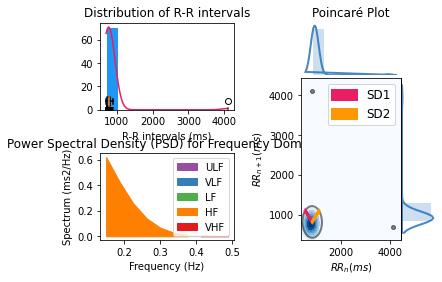

In [29]:
import neurokit2 as nk
hrv_indices = nk.hrv(data_IBI_one_participant["IBI_R_Peaks"], sampling_rate=RESAMPLING_FREQUENCY, show=True)
hrv_indices

---
# 3. Organize the dataset ready for feature extraction
---

The last example shows how to organize the dataset for classification tasks:

1. Remove NaN by merging the time-series per their respective `data_group`. They already have the same `ParticipantID`, `VideoID` and `TimeStamp`, thus it's easy to remove the column that indicates the type of data (*Annotations, Behavior, Physio*) so that the whole dataframe does not contain missing values.
2. In this case, we define the class labels in high/low arousal/valence according to the video's reference V-A levels: `[HAHL, HALV, LAHV, LA,LV]`. However, the same procedure can be used to label the target classes in other ways.

In [30]:
dgroup_colname = "data_type"        # Existing column to be removed
class_label_colname = "class_VA"    # Class column name to be created

# These columns are used as index to join df
basic_colnames = [participant_colname, video_colname, ts_colname]
basic_colnames

['ParticipantID', 'VideoID', 'TimeStamp']

In [31]:
# Mapping used according to the paper's information in Table 1
# doi: 10.1109/TMM.2021.3124080
MAPPING_VIDEO_TO_CLASS = {
    1: "HVHA",
    2: "HVLA",
    3: "LVHA",
    4: "LVLA",
    5: "HVHA",
    6: "HVLA",
    7: "LVHA",
    8: "LVLA",
}
# Create a function from the dictionary to apply on the final array
mapper_videoid_to_classes = np.vectorize(MAPPING_VIDEO_TO_CLASS.get)

In [32]:
# Where the compiled dataset will be stored
DATASET_POSTPROCESSED_WITHOUT_NAN = gen_path_temp("Dataset_CEAP_postprocessed", extension=".csv")

# Load or create dataframe with statistics of initial dataset
dataset_postprocessed_no_nan = None

try:
    dataset_postprocessed_no_nan = pd.read_csv(DATASET_POSTPROCESSED_WITHOUT_NAN)
    print("Data loaded from file")
except:
    print("Creating file")

    # Delete preprocessing level info (Full of labels saying `Frame`)
    df_ceap_with_Rpeaks = df_ceap_with_Rpeaks.drop(["processing_level"], axis=1)

    # Merge data from different groups to remove Nan values
    for pid in np.sort(df_ceap_with_Rpeaks[participant_colname].unique()):
        for vid in np.sort(df_ceap_with_Rpeaks[video_colname].unique()):
            # Stores the different data groups per time-series instance.
            df_instance = None
            for dg in DATA_GROUPS:
                print(f"P{pid} V{vid} G:{dg}")
                Q = ( (df_ceap_with_Rpeaks[participant_colname] == pid) 
                    & (df_ceap_with_Rpeaks[video_colname] == vid)
                    & (df_ceap_with_Rpeaks[dgroup_colname] == dg))
                
                selection_idx = df_ceap_with_Rpeaks[Q].index
                data_per_group = df_ceap_with_Rpeaks.loc[selection_idx].copy()

                # Load the data get the relevant columns that do not contain missing values
                data_per_group.drop(dgroup_colname, axis=1, inplace=True)
                data_per_group.set_index(basic_colnames, inplace=True)
                data_per_group.dropna(axis=1, how="all", inplace=True)

                # Add specific data group to time series
                df_instance = data_per_group if (df_instance is None) else df_instance.join(data_per_group)

            # Add joined dataset to general one
            df_instance.reset_index(inplace=True)
            dataset_postprocessed_no_nan = df_instance if (dataset_postprocessed_no_nan is None) else pd.concat([dataset_postprocessed_no_nan, df_instance], axis=0, ignore_index=True)

print("\tEnd")

# Map each video to the corresponding Class label
video_id_array = dataset_postprocessed_no_nan[video_colname]
dataset_postprocessed_no_nan[class_label_colname] = mapper_videoid_to_classes(video_id_array)


Creating file
P1.0 V1.0 G:Annotations
P1.0 V1.0 G:Behavior
P1.0 V1.0 G:Physio
P1.0 V2.0 G:Annotations
P1.0 V2.0 G:Behavior
P1.0 V2.0 G:Physio
P1.0 V3.0 G:Annotations
P1.0 V3.0 G:Behavior
P1.0 V3.0 G:Physio
P1.0 V4.0 G:Annotations
P1.0 V4.0 G:Behavior
P1.0 V4.0 G:Physio
P1.0 V5.0 G:Annotations
P1.0 V5.0 G:Behavior
P1.0 V5.0 G:Physio
P1.0 V6.0 G:Annotations
P1.0 V6.0 G:Behavior
P1.0 V6.0 G:Physio
P1.0 V7.0 G:Annotations
P1.0 V7.0 G:Behavior
P1.0 V7.0 G:Physio
P1.0 V8.0 G:Annotations
P1.0 V8.0 G:Behavior
P1.0 V8.0 G:Physio
P2.0 V1.0 G:Annotations
P2.0 V1.0 G:Behavior
P2.0 V1.0 G:Physio
P2.0 V2.0 G:Annotations
P2.0 V2.0 G:Behavior
P2.0 V2.0 G:Physio
P2.0 V3.0 G:Annotations
P2.0 V3.0 G:Behavior
P2.0 V3.0 G:Physio
P2.0 V4.0 G:Annotations
P2.0 V4.0 G:Behavior
P2.0 V4.0 G:Physio
P2.0 V5.0 G:Annotations
P2.0 V5.0 G:Behavior
P2.0 V5.0 G:Physio
P2.0 V6.0 G:Annotations
P2.0 V6.0 G:Behavior
P2.0 V6.0 G:Physio
P2.0 V7.0 G:Annotations
P2.0 V7.0 G:Behavior
P2.0 V7.0 G:Physio
P2.0 V8.0 G:Annotations
P2

In [33]:
# Target array (y)
video_id_array

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
460795    8.0
460796    8.0
460797    8.0
460798    8.0
460799    8.0
Name: VideoID, Length: 460800, dtype: float64

In [34]:
# Input data (X)
dataset_postprocessed_no_nan

,ParticipantID,VideoID,TimeStamp,Valence,Arousal,HM_Pitch,HM_Yaw,EM_Pitch,EM_Yaw,LEM_Pitch,...,RPD_PD,ACC_ACC_X,ACC_ACC_Y,ACC_ACC_Z,SKT_SKT,EDA_EDA,BVP_BVP,HR_HR,IBI_R_Peaks,class_VA
0,1.0,1.0,0.000,5.000,5.0,1.180000,1.250000,0.587000,-0.04100,1.133000,...,5.580000,-52.000000,23.0,30.000000,0.000000,0.165399,0.193771,85.530000,0.0,HVHA
1,1.0,1.0,0.033,5.000,5.0,1.173400,1.240925,0.744575,-0.03605,1.429175,...,5.580825,-52.240226,23.0,30.000000,0.000309,0.177006,0.131518,85.527358,0.0,HVHA
2,1.0,1.0,0.067,5.000,5.0,1.162550,1.190400,0.799600,-0.07145,1.501450,...,5.573575,-52.388821,23.0,30.000000,0.000628,0.188965,0.180567,85.524636,0.0,HVHA
3,1.0,1.0,0.100,5.000,5.0,1.144000,1.129500,0.794000,0.00450,1.483000,...,5.568000,-52.217916,23.0,29.579354,0.000938,0.200573,0.334518,85.521995,0.0,HVHA
4,1.0,1.0,0.133,5.000,5.0,1.125775,1.082575,0.772475,0.10970,1.429125,...,5.563400,-52.000000,23.0,29.432128,0.001247,0.212180,0.539940,85.519353,0.0,HVHA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460795,32.0,8.0,59.867,3.684,5.0,-4.517000,-64.280000,-0.674000,-81.47500,-0.971000,...,3.323000,57.000000,18.0,18.000000,0.342844,0.267380,0.684285,69.536670,0.0,LVLA
460796,32.0,8.0,59.900,3.684,5.0,-4.488000,-64.418000,-0.593000,-81.43300,-0.933000,...,3.320000,57.000000,18.0,18.000000,0.327735,0.254040,0.695759,69.535003,0.0,LVLA
460797,32.0,8.0,59.933,3.684,5.0,-4.481000,-64.561000,-0.173000,-80.87200,-0.455000,...,3.235000,57.000000,18.0,18.000000,0.312626,0.240701,0.688717,69.533335,0.0,LVLA
460798,32.0,8.0,59.967,3.684,5.0,-4.509000,-64.771000,0.897000,-78.52200,0.605000,...,3.293000,57.000000,18.0,18.000000,0.297517,0.227361,0.655287,69.531668,0.0,LVLA


In [35]:
# Check for missing values
dataset_postprocessed_no_nan.isna().sum(axis=0)

ParticipantID    0
VideoID          0
TimeStamp        0
Valence          0
Arousal          0
HM_Pitch         0
HM_Yaw           0
EM_Pitch         0
EM_Yaw           0
LEM_Pitch        0
LEM_Yaw          0
REM_Pitch        0
REM_Yaw          0
LPD_PD           0
RPD_PD           0
ACC_ACC_X        0
ACC_ACC_Y        0
ACC_ACC_Z        0
SKT_SKT          0
EDA_EDA          0
BVP_BVP          0
HR_HR            0
IBI_R_Peaks      0
class_VA         0
dtype: int64

Following steps may involve the transformation of each time series into tabular form with overlapping windows, or directly apply time-series classifiers...

In [36]:
# Examples to work with the data as MultiIndex (easier to apply feature extraction with rolling windows)
dataset_postprocessed_no_nan.set_index(["ParticipantID","VideoID","TimeStamp"])

Valence  Arousal  HM_Pitch     HM_Yaw  \
ParticipantID VideoID TimeStamp                                          
1.0           1.0     0.000        5.000      5.0  1.180000   1.250000   
                      0.033        5.000      5.0  1.173400   1.240925   
                      0.067        5.000      5.0  1.162550   1.190400   
                      0.100        5.000      5.0  1.144000   1.129500   
                      0.133        5.000      5.0  1.125775   1.082575   
...                                  ...      ...       ...        ...   
32.0          8.0     59.867       3.684      5.0 -4.517000 -64.280000   
                      59.900       3.684      5.0 -4.488000 -64.418000   
                      59.933       3.684      5.0 -4.481000 -64.561000   
                      59.967       3.684      5.0 -4.509000 -64.771000   
                      60.000       3.684      5.0 -4.527000 -64.959000   

                                 EM_Pitch    EM_Yaw  LEM_Pitch    LEM_Yaw  \
ParticipantID VideoID TimeStamp                                             
1.0           1.0     0.000      0.587000  -0.04100   1.133000  -0.417000   
                      0.033      0.744575  -0.03605   1.429175  -0.402150   
                      0.067      0.799600  -0.07145   1.501450  -0.418575   
                      0.100      0.794000   0.00450   1.483000  -0.298500   
                      0.133      0.772475   0.10970   1.429125  -0.134225   
...                                   ...       ...        ...        ...   
32.0          8.0     59.867    -0.674000 -81.47500  -0.971000 -81.211000   
                      59.900    -0.593000 -81.43300  -0.933000 -81.314000   
                      59.933    -0.173000 -80.87200  -0.455000 -80.848000   
                      59.967     0.897000 -78.52200   0.605000 -78.542000   
                      60.000     0.806000 -78.69800   0.393000 -78.665000   

                                 REM_Pitch    REM_Yaw  ...    RPD_PD  \
ParticipantID VideoID TimeStamp                        ...             
1.0           1.0     0.000       0.040000   0.335000  ...  5.580000   
                      0.033       0.060625   0.330050  ...  5.580825   
                      0.067       0.097400   0.275675  ...  5.573575   
                      0.100       0.105000   0.307500  ...  5.568000   
                      0.133       0.116175   0.353625  ...  5.563400   
...                                    ...        ...  ...       ...   
32.0          8.0     59.867     -0.378000 -81.739000  ...  3.323000   
                      59.900     -0.252000 -81.552000  ...  3.320000   
                      59.933      0.109000 -80.895000  ...  3.235000   
                      59.967      1.188000 -78.501000  ...  3.293000   
                      60.000      1.219000 -78.731000  ...  3.263000   

                                 ACC_ACC_X  ACC_ACC_Y  ACC_ACC_Z   SKT_SKT  \
ParticipantID VideoID TimeStamp                                              
1.0           1.0     0.000     -52.000000       23.0  30.000000  0.000000   
                      0.033     -52.240226       23.0  30.000000  0.000309   
                      0.067     -52.388821       23.0  30.000000  0.000628   
                      0.100     -52.217916       23.0  29.579354  0.000938   
                      0.133     -52.000000       23.0  29.432128  0.001247   
...                                    ...        ...        ...       ...   
32.0          8.0     59.867     57.000000       18.0  18.000000  0.342844   
                      59.900     57.000000       18.0  18.000000  0.327735   
                      59.933     57.000000       18.0  18.000000  0.312626   
                      59.967     57.000000       18.0  18.000000  0.297517   
                      60.000     57.000000       18.0  18.000000  0.282409   

                                  EDA_EDA   BVP_BVP      HR_HR  IBI_R_Peaks  \
ParticipantID VideoID TimeStamp      

In [37]:
print('End of notebook')

End of notebook
